## Single grid point

In [1]:
import xarray as xr
import pandas
import glob
import matplotlib.pyplot as plt
import matplotlib as mpl

In [2]:
lon = 153.25
lat = -31.0

In [3]:
thw = xr.open_dataset('/g/data/e14/cp3790/Charuni/Tasmania/aus-coastal-sev.nc').sel(latitude=lat, longitude=lon)
mhw = xr.open_dataset('/g/data/e14/cp3790/Charuni/Tasmania/aus-ocean-sev-2.nc').sel(latitude=lat, longitude=lon)

In [4]:
thw_sev = thw.severity
thw_days = xr.where(thw_sev>1, 1, 0)

In [5]:
mhw_sev = mhw.severity
mhw_days = xr.where(mhw_sev>1, 1, 0)

In [6]:
def event_durations(event_mask, dim='time'):
    """
    Returns the lengths of events marked by 'event_mask'. Where 'event_mask' is 
    true an event is deemed active
    """
    event_stats = []
    
    assert event_mask.ndim == 1, "Only 1d arrays are implemented"

    # Loop over each entry, adding records for events to 'event_stats'
    current_event = None
    for i in range(event_mask.sizes[dim]):
        event_active = event_mask.isel({dim:i})
    
        if event_active:
            if not current_event:
                # A new event
                current_event = {'start': event_mask[dim].data[i], 'duration': 1}
            else:
                # An existing event
                current_event['duration'] += 1
        else:
            if current_event:
                # Event has finished, add to the record array
                event_stats.append(current_event)
                current_event = None

    if current_event:
        # Event active at the end
        event_stats.append(current_event)

    return pandas.DataFrame.from_records(event_stats, index='start')

In [7]:
thw_duration = event_durations(thw_days, dim='time')

In [8]:
mhw_duration = event_durations(mhw_days, dim='time')

In [9]:
thw_duration

,duration
start,
1982-04-25,3
1983-03-21,4
1983-09-12,3
1984-11-20,3
1985-12-19,4
...,...
2018-11-20,6
2018-12-01,4
2018-12-13,3


In [10]:
mhw_duration

,duration
start,
1982-01-02,6
1982-02-13,5
1982-03-14,22
1982-04-07,6
1982-04-14,15
...,...
2018-03-28,44
2018-06-20,5
2018-08-03,19


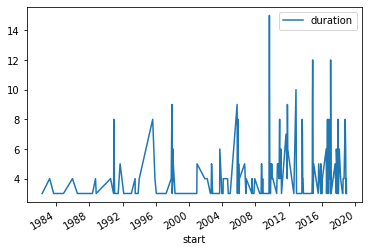

In [11]:
thw_duration.plot()

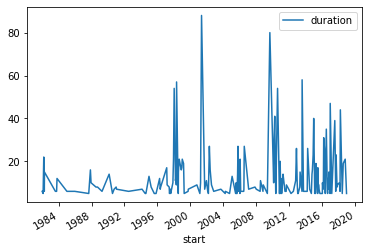

In [12]:
mhw_duration.plot()

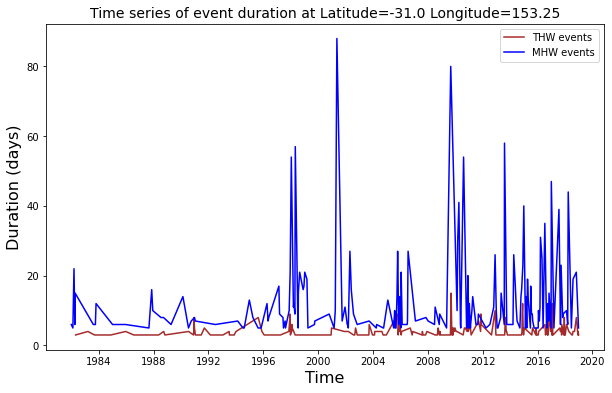

In [15]:
import scipy.stats as st
fig, ax = plt.subplots(figsize=(10,6)) 
plt.plot(thw_duration, label='THW events', color='brown')
plt.plot(mhw_duration, label='MHW events', color='blue')
plt.legend()
#plt.ylim(ymin=3, ymax=16)
plt.ylabel('Duration (days)', fontsize=16)
plt.title('Time series of event duration at Latitude=%s'%str(lat)+' Longitude=%s'%str(lon), fontsize=14)
plt.xlabel('Time', fontsize=16)
plt.show()
#plt.savefig('/g/data/e14/cp3790/Charuni/Tasmania/thw-duration-east')

In [50]:
%load_ext line_profiler

In [52]:
%lprun -f event_durations event_durations(thw_days)

## Multidimensional array

In [22]:
# https://github.com/pydata/xarray/issues/2249 
# this function is used to calculate the number of consequent heatwave days in a time-series and 
# store it in the original 3D shape:

def my_function(x):
    mask = (x.severity > 1 )[:,0]   #mask heatwave days i.e. days with severity > 1
    hwday_num = mask.groupby( ~mask.cumsum() ).sum() # calculate number of consecutive heatwave days (i.e. number of consecutive <True> values in a time-series) 
     
    index = np.where((((mask.shift(time=-1).fillna(False)) - mask)==-1) & (mask==True))[0] # shift the mask by one time step relative to original and calculate the difference between them to identify last <True> index in a heatwave day sequence
    hw_days = x.severity[:,0].copy(); hw_days[:] = 0.0 #create an empty array of hw days
    hw_days[index] = hwday_num[hwday_num>0]  # store the number of hw days in the last day of every hw day period 
    return hw_days

In [23]:
thw = xr.open_dataset('/g/data/e14/cp3790/Charuni/Tasmania/aus-coastal-sev.nc')

In [24]:
# stack lat/lons to reduce the dimension and to provide only a time-series to my_function()

stacked = thw.stack(allpoints=['latitude','longitude'])

In [25]:
# run my_function over every grid cell

hw_day_number_stacked = stacked.groupby('allpoints').apply(my_function) 

ValueError: shape mismatch: value array of shape (1050,) could not be broadcast to indexing result of shape (194,)

In [ ]:
hw_day_num = hw_day_num_stacked.unstack('allpoints')